# Comparação entre os modelos

## Importação das bibliotecas


In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import glob
import pandas as pd
import numpy as np
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix

# 1 Comparação entre os modelos NaiveBayes vs LogisticRegression 

## 1.1 Carregar Metricas dos modelos


In [2]:
with open("models/01_logistic_regression/logistic_regression_metrics.json") as f:
    metrics_lr = json.load(f)

with open("models/02_naive_bayes/naive_bayes_metrics.json") as f:
    metrics_nb = json.load(f)

## 1.2 Organizar dados em DataFrame

In [3]:
df = pd.DataFrame([
    metrics_lr,
    metrics_nb
])

In [4]:
# Converter tempos para ms/segundos com precisão
df["inference_time_ms"] = df["inference_time_ms"].round(2)
df["train_time_sec"] = df["train_time_sec"].round(2)

## 1.3 Visualização Comparativa

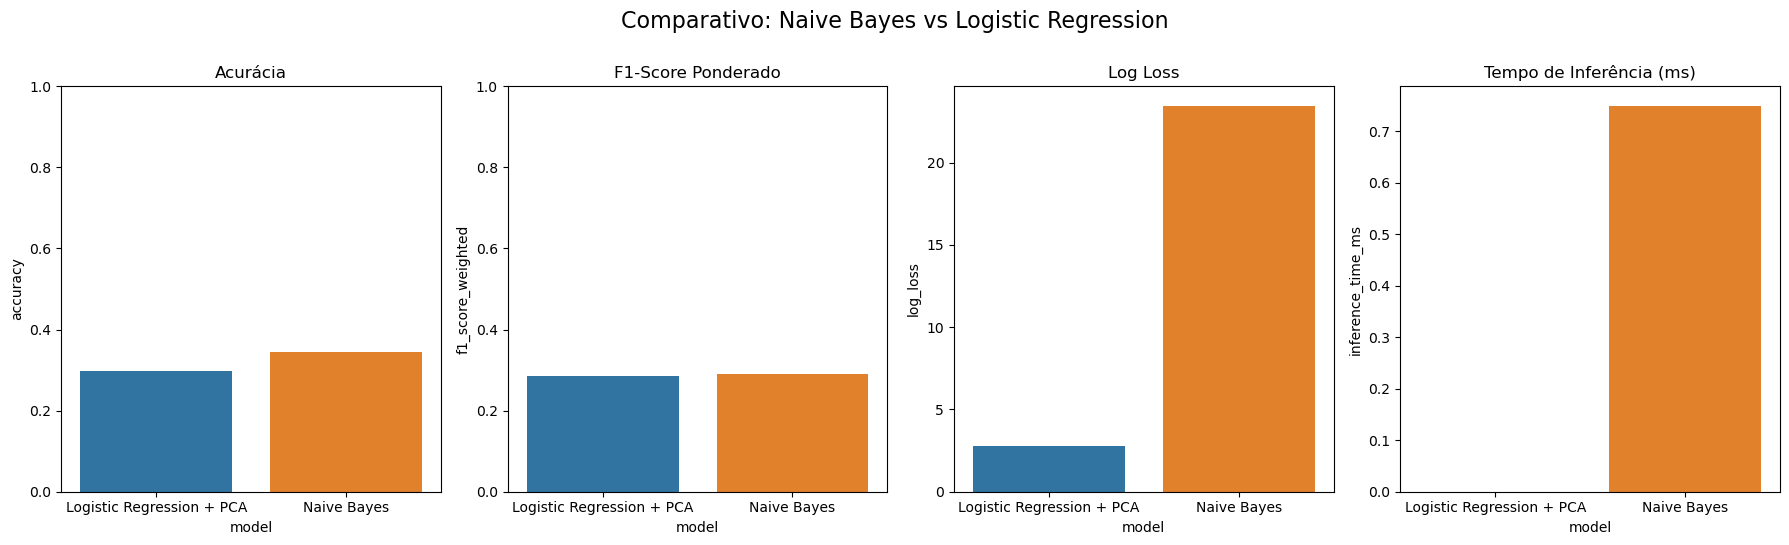

In [5]:
plt.figure(figsize=(18, 5))

# Acurácia
plt.subplot(1, 4, 1)
sns.barplot(x="model", y="accuracy", data=df)
plt.title("Acurácia")
plt.ylim(0, 1)

# F1-Score
plt.subplot(1, 4, 2)
sns.barplot(x="model", y="f1_score_weighted", data=df)
plt.title("F1-Score Ponderado")
plt.ylim(0, 1)

# Log Loss
plt.subplot(1, 4, 3)
sns.barplot(x="model", y="log_loss", data=df)
plt.title("Log Loss")

# Tempo de Inferência
plt.subplot(1, 4, 4)
sns.barplot(x="model", y="inference_time_ms", data=df)
plt.title("Tempo de Inferência (ms)")

plt.tight_layout()
plt.suptitle("Comparativo: Naive Bayes vs Logistic Regression", fontsize=16, y=1.08)
plt.show()


## 1.4 Tabela de Comparacao

In [6]:
print("\n Tabela comparativa das métricas:\n")
display(df[["model", "accuracy", "f1_score_weighted", "log_loss", "train_time_sec", "inference_time_ms"]])


 Tabela comparativa das métricas:



,model,accuracy,f1_score_weighted,log_loss,train_time_sec,inference_time_ms
0,Logistic Regression + PCA,0.296651,0.286213,2.775591,57.57,NaN
1,Naive Bayes,0.344498,0.291166,23.455161,0.25,0.75


## 1.5 Matriz de confusão

In [7]:
# Função para carregar imagens e rotulá-las
def carregar_imagens(pasta, image_size=(64, 64)):
    X, y = [], []
    for classe in sorted(os.listdir(pasta)):
        caminho_classe = os.path.join(pasta, classe)
        if not os.path.isdir(caminho_classe):
            continue
        for arquivo in glob.glob(os.path.join(caminho_classe, "*.jpg")):
            img = cv2.imread(arquivo, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, image_size)
            X.append(img.flatten() / 255.0)
            y.append(classe)
    return np.array(X), np.array(y)

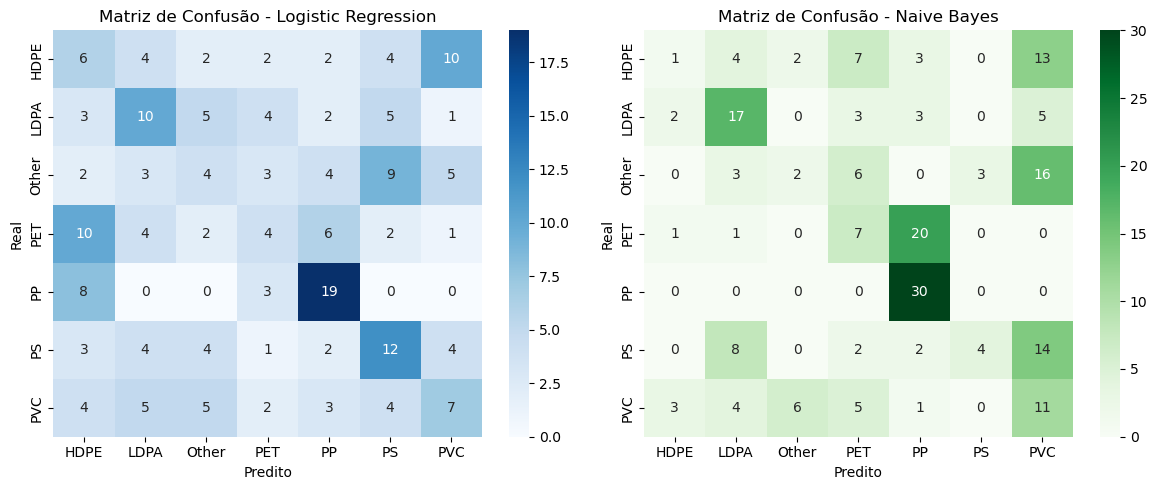

In [8]:
# Carregar modelos e encoder
lr_model = joblib.load("models/01_logistic_regression/logistic_regression_model.joblib")
nb_model = joblib.load("models/02_naive_bayes/naive_bayes_model.joblib")
le = joblib.load("models/02_naive_bayes/label_encoder_naive_bayes.joblib")

# Recarregar dados de teste

X_test, y_test = carregar_imagens("./datasets/Plastic_Classification/test")
y_test_enc = le.transform(y_test)

# Aplicar PCA para logistic regression
pca = joblib.load("models/01_logistic_regression/pca_transformer_logistic_regression.joblib")
X_test_pca = pca.transform(X_test)

# Predições
y_pred_lr = lr_model.predict(X_test_pca)
y_pred_nb = nb_model.predict(X_test)

# Matrizes
cm_lr = confusion_matrix(y_test_enc, y_pred_lr)
cm_nb = confusion_matrix(y_test_enc, y_pred_nb)

# Plotar lado a lado
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusão - Logistic Regression")
plt.xlabel("Predito")
plt.ylabel("Real")

plt.subplot(1, 2, 2)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusão - Naive Bayes")
plt.xlabel("Predito")
plt.ylabel("Real")

plt.tight_layout()
plt.show()

## 1.6 Exibir previsões

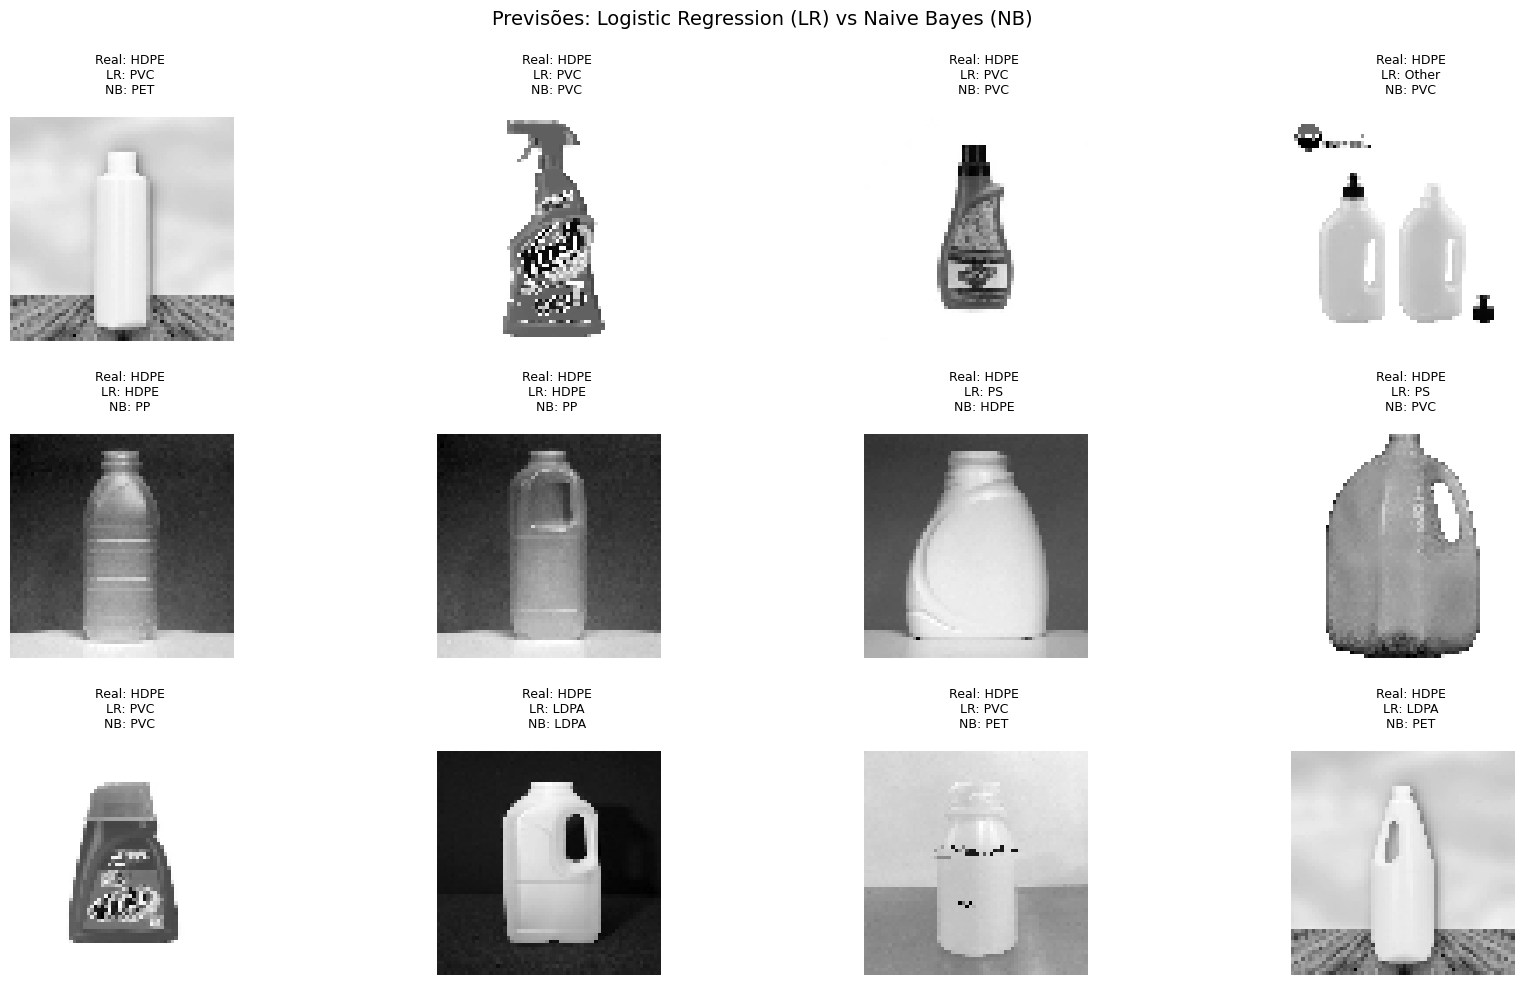

In [9]:
# Recriar imagens (64x64) para visualização
X_test_imgs = X_test.reshape((-1, 64, 64)) * 255.0  # desnormaliza para imagem real

# Decodificar rótulos reais e preditos
real_labels = le.inverse_transform(y_test_enc)
pred_lr_labels = le.inverse_transform(y_pred_lr)
pred_nb_labels = le.inverse_transform(y_pred_nb)

# Mostrar as 12 primeiras imagens com real e predições dos dois modelos
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_test_imgs[i], cmap="gray")
    plt.axis("off")
    plt.title(f"""
    Real: {real_labels[i]}
    LR: {pred_lr_labels[i]}
    NB: {pred_nb_labels[i]}
    """, fontsize=9)
plt.suptitle("Previsões: Logistic Regression (LR) vs Naive Bayes (NB)", fontsize=14)
plt.tight_layout()
plt.show()


# 2 Comparação entre os modelos Random Forest vs Naive Bayes vs Logistic Regression 

## 2.1 Carregar Metricas dos modelos salvos

In [11]:
with open("models/01_logistic_regression/logistic_regression_metrics.json") as f:
    metrics_lr = json.load(f)

with open("models/02_naive_bayes/naive_bayes_metrics.json") as f:
    metrics_nb = json.load(f)

with open("models/03_random_forest/random_forest_metrics.json") as f:
    metrics_rf = json.load(f)

In [12]:
# Organizar no DataFrame
results = pd.DataFrame([metrics_lr, metrics_nb, metrics_rf])

# Arredondar valores para melhor leitura
results["train_time_sec"] = results["train_time_sec"].round(2)
results["inference_time_ms"] = results["inference_time_ms"].round(2)

## 2.3 Visualização Comparativa das métricas

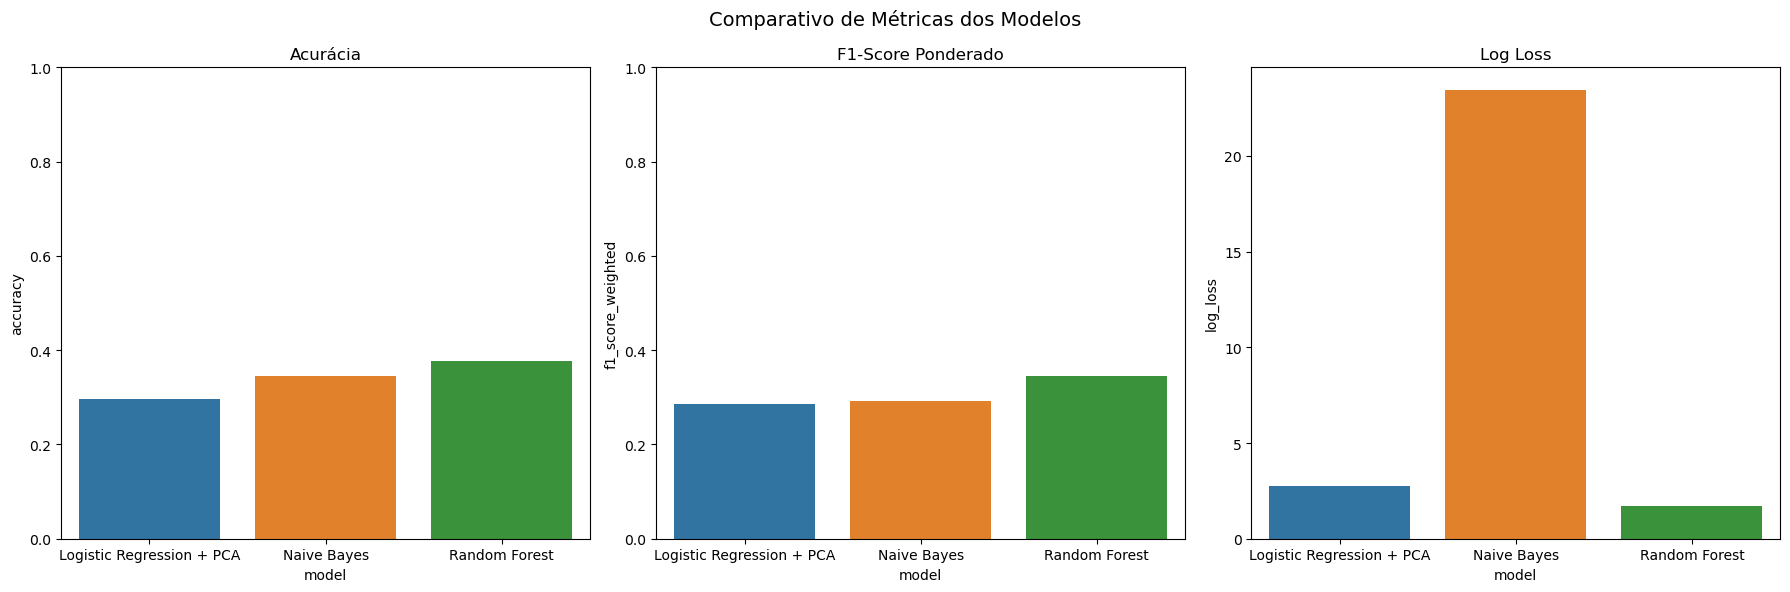

In [14]:
plt.figure(figsize=(18, 6))

# Acurácia
plt.subplot(1, 3, 1)
sns.barplot(data=results, x="model", y="accuracy")
plt.title("Acurácia")
plt.ylim(0, 1)

# F1-Score
plt.subplot(1, 3, 2)
sns.barplot(data=results, x="model", y="f1_score_weighted")
plt.title("F1-Score Ponderado")
plt.ylim(0, 1)

# Log Loss
plt.subplot(1, 3, 3)
sns.barplot(data=results, x="model", y="log_loss")
plt.title("Log Loss")

plt.suptitle("Comparativo de Métricas dos Modelos", fontsize=14)
plt.tight_layout()
plt.show()

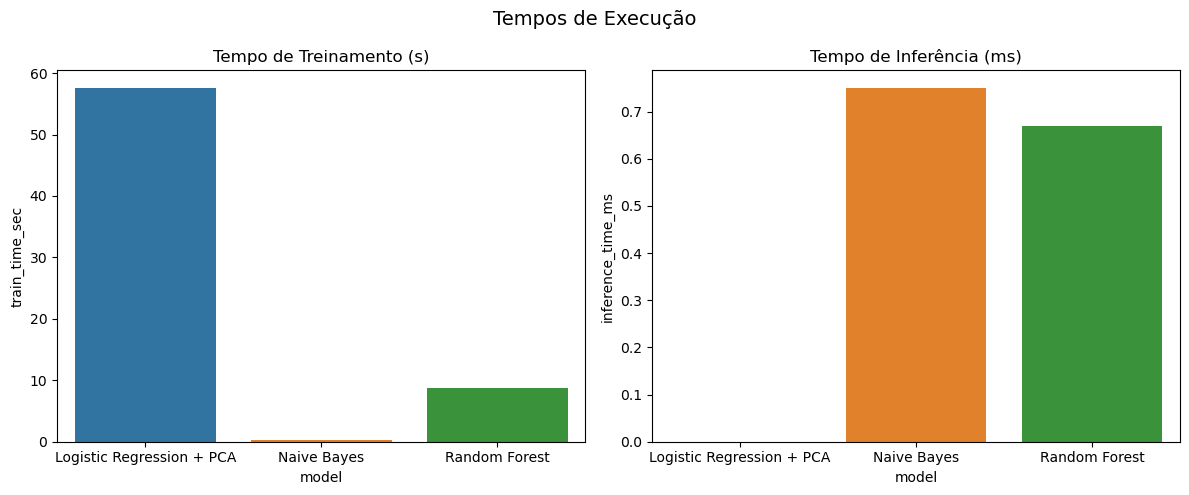

In [16]:
plt.figure(figsize=(12, 5))

# Tempo de Treinamento
plt.subplot(1, 2, 1)
sns.barplot(data=results, x="model", y="train_time_sec")
plt.title("Tempo de Treinamento (s)")

# Tempo de Inferência
plt.subplot(1, 2, 2)
sns.barplot(data=results, x="model", y="inference_time_ms")
plt.title("Tempo de Inferência (ms)")

plt.suptitle("Tempos de Execução", fontsize=14)
plt.tight_layout()
plt.show()

## 2.5 Matriz de confusão

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished


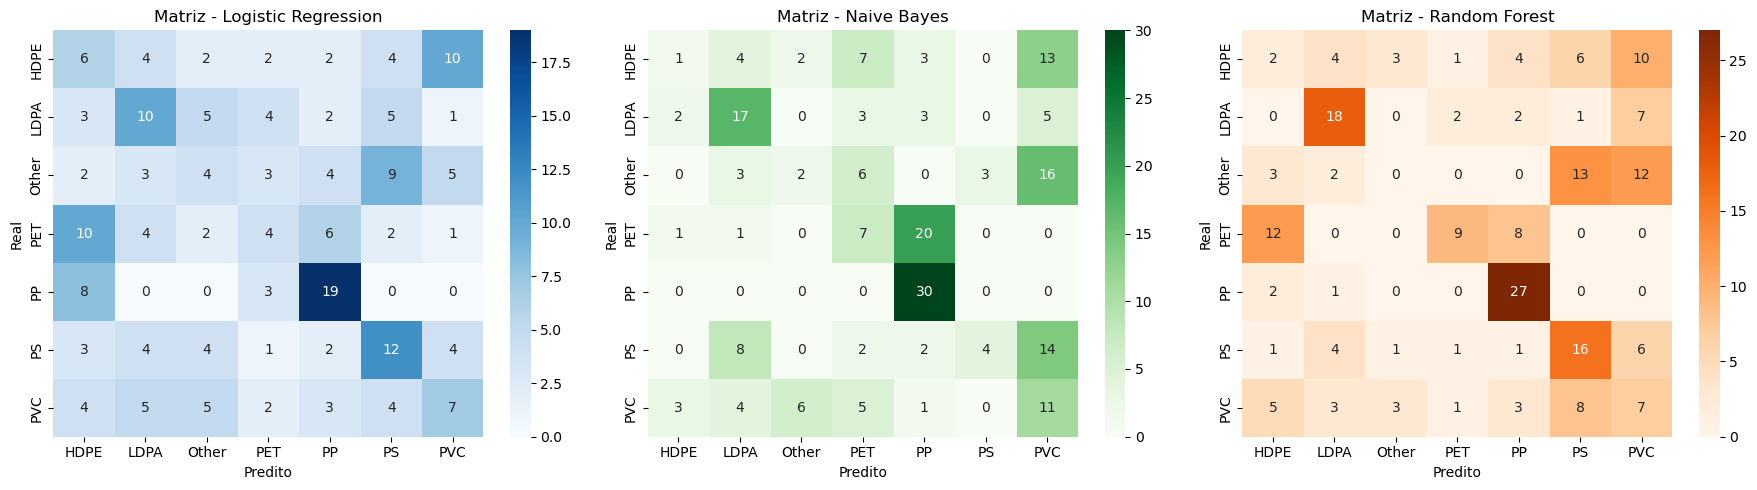

In [20]:
# Carregar dados e modelos
le = joblib.load("models/03_random_forest/label_encoder_random_forest.joblib")
X_test, y_test = joblib.load("models/test_data_for_comparisons.joblib")
y_test_enc = le.transform(y_test)

# Carregar modelos
lr_model = joblib.load("models/01_logistic_regression/logistic_regression_model.joblib")
nb_model = joblib.load("models/02_naive_bayes/naive_bayes_model.joblib")
rf_model = joblib.load("models/03_random_forest/random_forest_model.joblib")

# Aplicar PCA se necessario para LR
pca = joblib.load("models/01_logistic_regression/pca_transformer_logistic_regression.joblib")
X_test_pca = pca.transform(X_test)

# Predições
y_pred_lr = lr_model.predict(X_test_pca)
y_pred_nb = nb_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Matrizes de Confusão
cm_lr = confusion_matrix(y_test_enc, y_pred_lr)
cm_nb = confusion_matrix(y_test_enc, y_pred_nb)
cm_rf = confusion_matrix(y_test_enc, y_pred_rf)

# Plotar
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz - Logistic Regression")
plt.xlabel("Predito")
plt.ylabel("Real")

plt.subplot(1, 3, 2)
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Greens", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz - Naive Bayes")
plt.xlabel("Predito")
plt.ylabel("Real")

plt.subplot(1, 3, 3)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Oranges", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz - Random Forest")
plt.xlabel("Predito")
plt.ylabel("Real")

plt.tight_layout()
plt.show()


# 3 Comparação entre os modelos Random Forest vs Naive Bayes vs Logistic Regression vs SM

## 3.1 Carregar Metricas dos modelos salvos

In [23]:
with open("models/01_logistic_regression/logistic_regression_metrics.json") as f:
    metrics_lr = json.load(f)

with open("models/02_naive_bayes/naive_bayes_metrics.json") as f:
    metrics_nb = json.load(f)

with open("models/03_random_forest/random_forest_metrics.json") as f:
    metrics_rf = json.load(f)

with open("models/04_svm/svm_metrics.json") as f:
    metrics_svm = json.load(f)

In [24]:
# Organizar no DataFrame
results = pd.DataFrame([metrics_lr, metrics_nb, metrics_rf, metrics_svm])

# Arredondar valores para melhor leitura
results["train_time_sec"] = results["train_time_sec"].round(2)
results["inference_time_ms"] = results["inference_time_ms"].round(2)

## 3.2 Visualização Comparativa das métricas

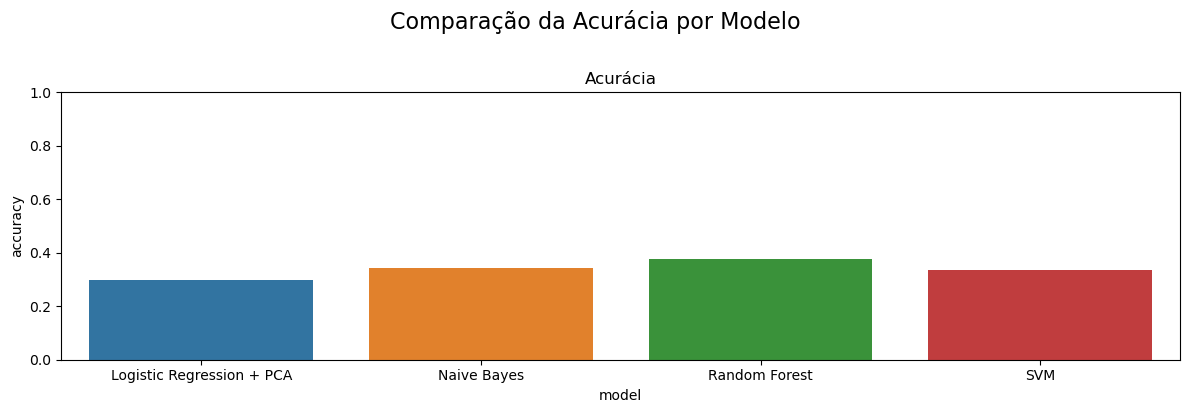

In [39]:
plt.figure(figsize=(12, 4))  

# Acurácia
plt.subplot()
sns.barplot(data=results, x="model", y="accuracy")
plt.title("Acurácia")
plt.ylim(0, 1)
plt.suptitle("Comparação da Acurácia por Modelo", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


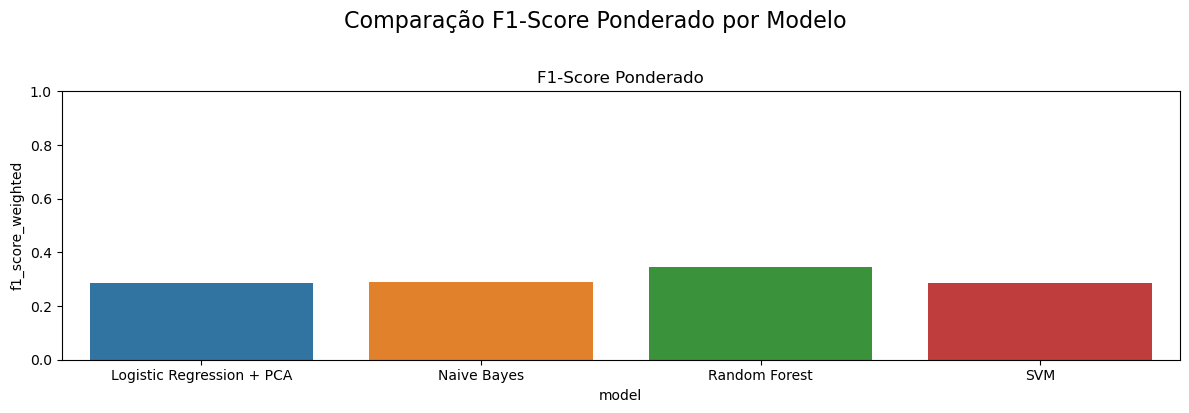

In [38]:
# F1-Score Ponderado
plt.figure(figsize=(12, 4))  

plt.subplot()
sns.barplot(data=results, x="model", y="f1_score_weighted")
plt.title("F1-Score Ponderado")
plt.ylim(0, 1)

plt.suptitle("Comparação F1-Score Ponderado por Modelo", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


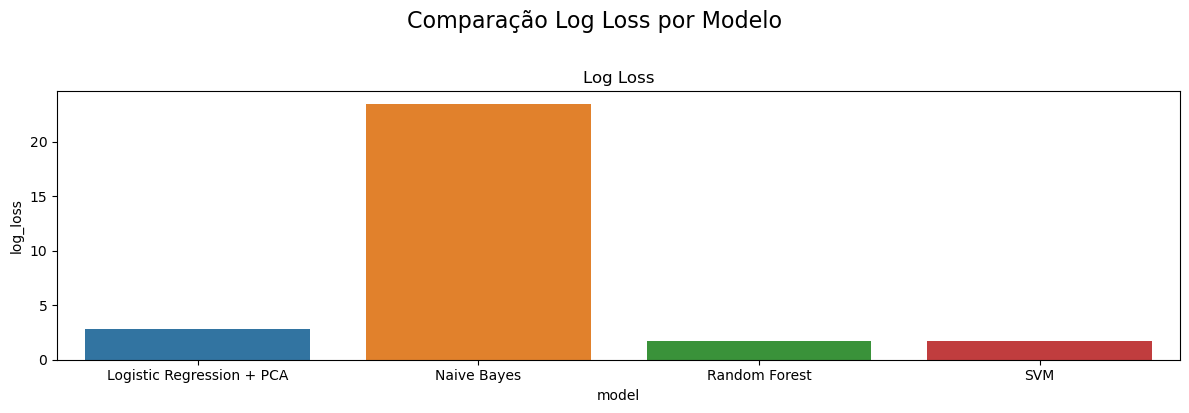

In [40]:
# Log Loss
plt.figure(figsize=(12, 4))  

plt.subplot()
sns.barplot(data=results, x="model", y="log_loss")
plt.title("Log Loss")

plt.suptitle("Comparação Log Loss por Modelo", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

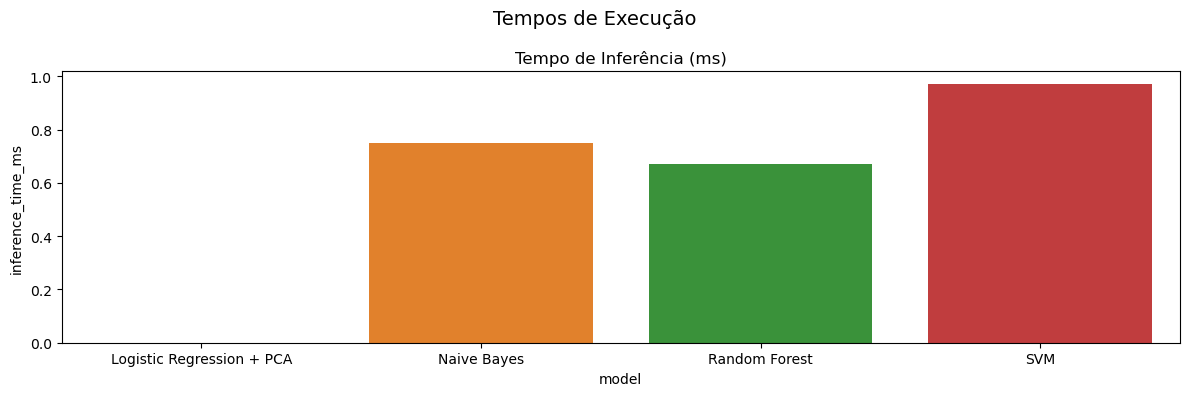

In [44]:
# Tempo de Inferência
plt.figure(figsize=(12, 4))  

plt.subplot()
sns.barplot(data=results, x="model", y="inference_time_ms")
plt.title("Tempo de Inferência (ms)")

plt.suptitle("Tempos de Execução", fontsize=14)
plt.tight_layout()
plt.show()

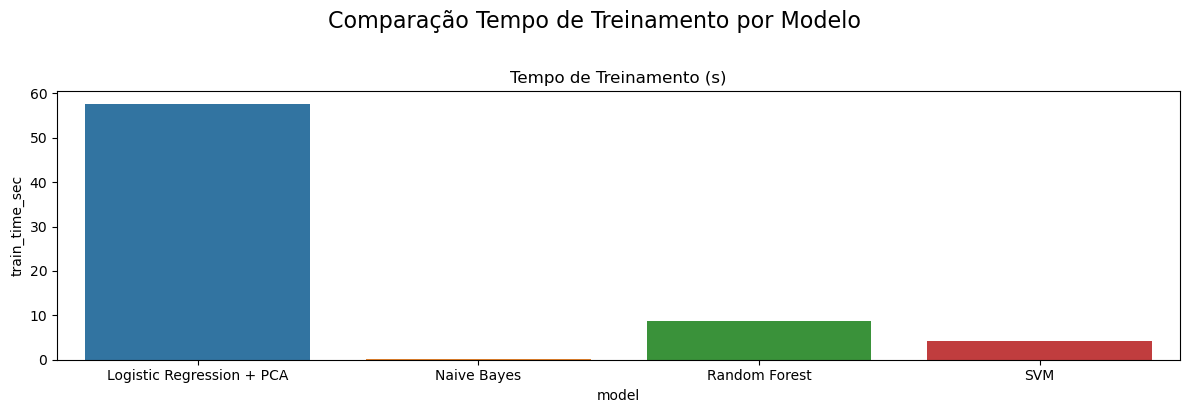

In [42]:
# Tempo de Treinamento
plt.figure(figsize=(12, 4))  

plt.subplot()
sns.barplot(data=results, x="model", y="train_time_sec")
plt.title("Tempo de Treinamento (s)")

plt.suptitle("Comparação Tempo de Treinamento por Modelo", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 3.5 Matriz de confusão

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128290 (\N{INPUT SYMBOL FOR NUMBERS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


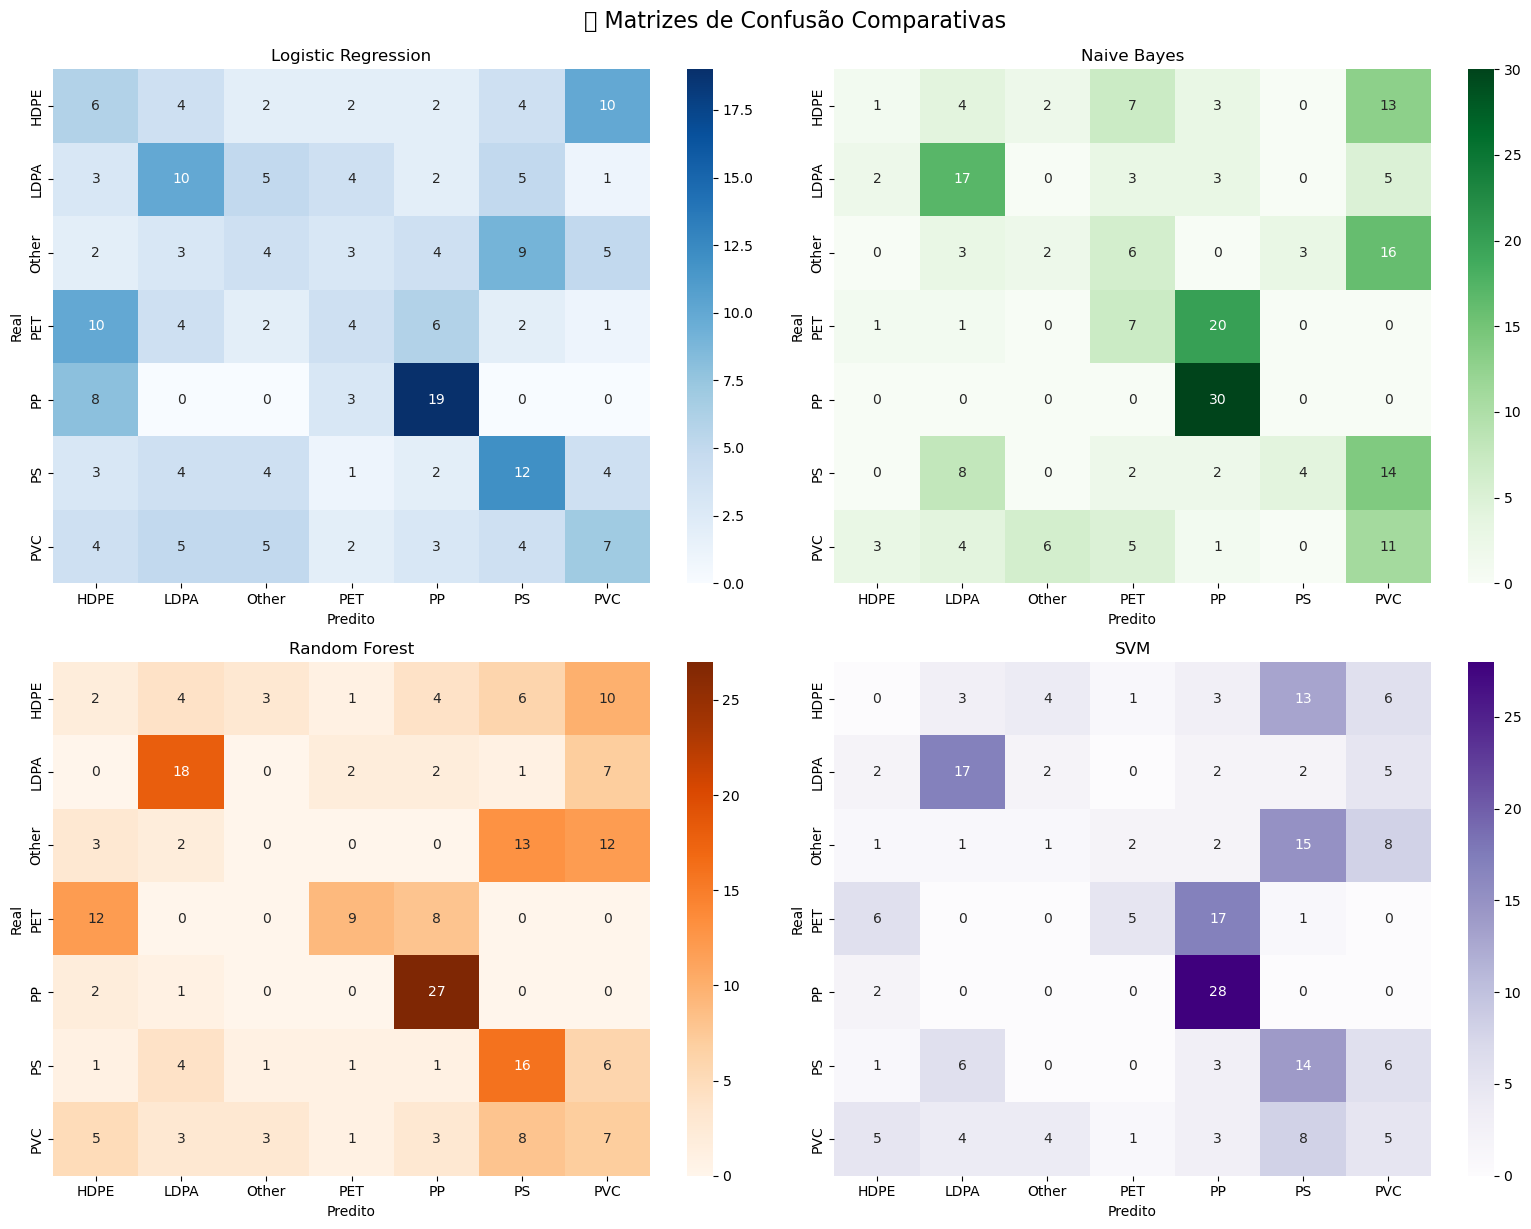

In [46]:
# Carregar dados e modelos
le = joblib.load("models/04_svm/label_encoder_svm.joblib")
X_test, y_test = joblib.load("models/test_data_for_comparisons.joblib")
y_test_enc = le.transform(y_test)

# Carregar modelos
lr_model = joblib.load("models/01_logistic_regression/logistic_regression_model.joblib")
nb_model = joblib.load("models/02_naive_bayes/naive_bayes_model.joblib")
rf_model = joblib.load("models/03_random_forest/random_forest_model.joblib")
svm_model = joblib.load("models/04_svm/svm_model.joblib")

# Aplicar PCA se necessário
pca = joblib.load("models/01_logistic_regression/pca_transformer_logistic_regression.joblib")
X_test_pca = pca.transform(X_test)

# Predições
y_pred_lr = lr_model.predict(X_test_pca)
y_pred_nb = nb_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test_pca)

# Matrizes de Confusão
cm_lr = confusion_matrix(y_test_enc, y_pred_lr)
cm_nb = confusion_matrix(y_test_enc, y_pred_nb)
cm_rf = confusion_matrix(y_test_enc, y_pred_rf)
cm_svm = confusion_matrix(y_test_enc, y_pred_svm)

# Plotar
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", ax=axes[0, 0], xticklabels=le.classes_, yticklabels=le.classes_)
axes[0, 0].set_title("Logistic Regression")

sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Greens", ax=axes[0, 1], xticklabels=le.classes_, yticklabels=le.classes_)
axes[0, 1].set_title("Naive Bayes")

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Oranges", ax=axes[1, 0], xticklabels=le.classes_, yticklabels=le.classes_)
axes[1, 0].set_title("Random Forest")

sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Purples", ax=axes[1, 1], xticklabels=le.classes_, yticklabels=le.classes_)
axes[1, 1].set_title("SVM")

for ax in axes.flatten():
    ax.set_xlabel("Predito")
    ax.set_ylabel("Real")

plt.tight_layout()
plt.suptitle("Matrizes de Confusão Comparativas", fontsize=16, y=1.02)
plt.show()